# ISIBrno-AIMT
ISIBrno-AIMT is the winner of the [Will Two Do?](https://physionet.org/content/challenge-2021/1.0.3/sources/) challenge from [physionet.org](https://physionet.org/) 

[Source Code](https://physionet.org/static/published-projects/challenge-2021/1.0.3/sources/ISIBrnoAIMT.zip)
[Paper](https://www.cinc.org/archives/2021/pdf/CinC2021-014.pdf)
[leaderboard](https://moody-challenge.physionet.org/2021/results/)

In [1]:
import pickle
import os
import sys
import torch
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

from models.m02_BagOfWords_ISIBrnoAIMT.train import *
from models.m02_BagOfWords_ISIBrnoAIMT.model import NN
from models.m02_BagOfWords_ISIBrnoAIMT.dataset import PtbXlDataset

In [2]:
os.chdir('..')

### Bag of Words with 20 Words

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

n_BoW = 20
dataset = PtbXlDataset('data_ptb-xl/', 'test', n_BoW)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = NN(n_BoW).to(device)
model.load_state_dict(torch.load(f'models/m02_BagOfWords_ISIBrnoAIMT/model_{n_BoW}_BoW.pt'))

<All keys matched successfully>

In [4]:
y, pred = get_predictions(model, dataloader)
bow_columns = pd.read_csv('data_ptb-xl/bag_of_words/train_20_BoW.csv').columns[1:]

In [5]:
y = pd.DataFrame(y, columns=bow_columns)
pred = pd.DataFrame(pred, columns=bow_columns)

In [6]:
f1 = f1_score(y, pred, average='weighted')
iou = jaccard_score(y, pred, average='weighted')

print(f'F1: {round(f1, 3)}\nIOU: {round(iou, 3)}')

F1: 0.611
IOU: 0.485


In [7]:
performance_data = []

for label in y.columns:
    f1 = f1_score(y[label], pred[label])
    precision = precision_score(y[label], pred[label], zero_division=0)
    recall = recall_score(y[label], pred[label])
    jaccard = jaccard_score(y[label], pred[label])
    
    performance_data.append({'Label': label, 'precision': precision, 'recall': recall, 'f1': f1, 'jaccard': jaccard})

performance_summary = pd.DataFrame(performance_data)

performance_summary

,Label,precision,recall,f1,jaccard
0,46,0.730897,0.990991,0.841300,0.726073
1,abnormal,0.244424,1.000000,0.392831,0.244424
2,block,0.160674,1.000000,0.276863,0.160674
3,branch,0.098316,1.000000,0.179030,0.098316
4,bundle,0.098316,1.000000,0.179030,0.098316
5,ecg,0.395084,1.000000,0.566395,0.395084
6,in,0.244424,1.000000,0.392831,0.244424
7,infarction,0.154756,1.000000,0.268033,0.154756
8,inferior,0.127902,1.000000,0.226796,0.127902
9,leads,0.101047,1.000000,0.183547,0.101047


### Bag of Words with n Words

In [8]:
torch.manual_seed(42)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

BoW = [20, 50, 100, 200, 500, 1000, 1500]
f1, iou = [], []

for n_BoW in BoW:
    dataset = PtbXlDataset('data_ptb-xl/', 'test', n_BoW)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    model = NN(n_BoW).to(device)
    model.load_state_dict(torch.load(f'models/m02_BagOfWords_ISIBrnoAIMT/model_{n_BoW}_BoW.pt'))
    
    y, pred = get_predictions(model, dataloader)
    bow_columns = pd.read_csv(f'data_ptb-xl/bag_of_words/train_{n_BoW}_BoW.csv').columns[1:]
    
    y = pd.DataFrame(y, columns=bow_columns)
    pred = pd.DataFrame(pred, columns=bow_columns)
    
    f1.append(f1_score(y, pred, average='weighted'))
    iou.append(jaccard_score(y, pred, average='weighted'))

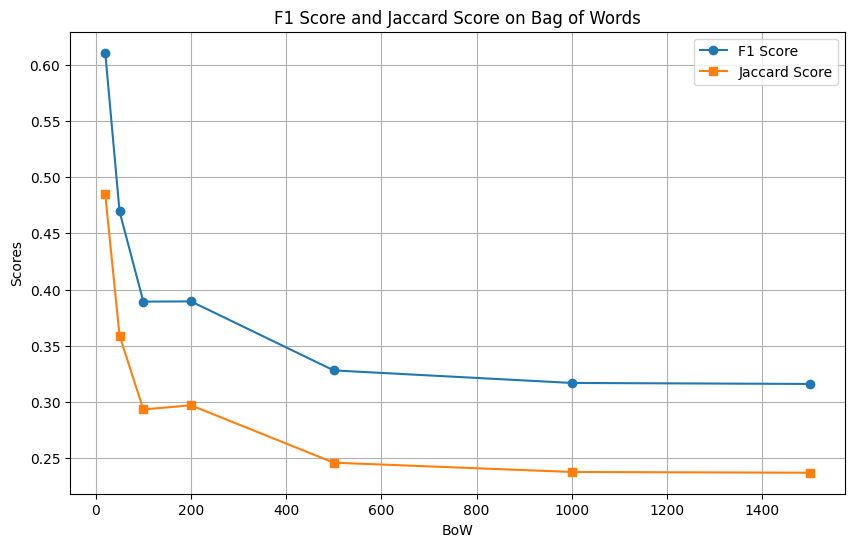

In [9]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(BoW, f1, marker='o', label='F1 Score')
plt.plot(BoW, iou, marker='s', label='Jaccard Score')

# Adding titles and labels
plt.title('F1 Score and Jaccard Score on Bag of Words')
plt.xlabel('BoW')
plt.ylabel('Scores')

# Adding legend
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()